此代码主要是仿照MIPPI模型建立一个预测蛋白质分类模型，以及评估模型的性能。

In [3]:
#导入所需要的python包和模块
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
# from keras.metrics import sparse_top_k_categorical_accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import tensorflow.keras.backend as K
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import sys
import pandas as pd
import numpy as np
from PIL import Image
import io
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import scipy
from scipy.stats import chi2_contingency
from scipy import stats
from mippiNetbuild3 import *
# sys.path.append('../input/mippi0801')
# from transformer import *
np.random.seed(0)
os.chdir('/data/zhangjian/graduate_project/dataset_for_Tm/high-data/result_high_data')

2024-04-23 15:11:29.773709: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 15:11:35.553016: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 15:11:35.578078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 15:11:48.318273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import math
def nearest_multiple_of_5(number):
    # 将给定数值除以5并向下取整
    nearest_multiple = math.floor(number / 5) * 5
    return nearest_multiple

# 绘制条形图
def plot_raw(data,log=False):
    # 划分区段
    bins = range(nearest_multiple_of_5(data['Tm'].min())+1, int(data['Tm'].max()) + 6, 5)

    # 计算每个分组中的蛋白质数量
    counts, bin_edges = np.histogram(data['Tm'], bins=bins)

    # 对数量进行对数变换
    if log == True:
        counts_log = np.log10(counts)
        counts = counts_log
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(counts)), counts, color='skyblue')
    plt.bar(range(len(counts)), counts, color='skyblue')
    plt.title('Protein Count in  high data')
    plt.xlabel('Tm Result Bins')
    

    
    if log == True:
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts_log[i]:.2f}",
                 ha='center', va='bottom')
        plt.yticks(np.arange(0, np.floor(counts_log.max()) + 1, 1))
        plt.ylabel('log(Protein Count)')
        plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right')
    if log == False:
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts[i]}",
                     ha='center', va='bottom')
        #plt.yticks(np.arange(0, np.floor(counts.max()) + 1, 1))
        plt.ylabel('Protein Count')
        plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right')
    plt.show()


In [5]:
os.chdir('/data/zhangjian/graduate_project/dataset_for_Tm/high-data/result_high_data')
train_id = 'train_model2'
train_log_path = r'./' + train_id
if not os.path.exists(train_log_path):
    os.makedirs(train_log_path)
best_acc_model_path = os.path.join(train_log_path, 'bestAcc.h5')
best_loss_model_path = os.path.join(train_log_path, 'bestLoss.h5')
test_ba_npz_path = os.path.join(train_log_path, 'ba_pred.npz')
test_bl_npz_path = os.path.join(train_log_path, 'bl_pred.npz')

label_true_path = os.path.join(train_log_path, 'all_true.npy')
label_pred_path = os.path.join(train_log_path, 'all_pred.npy')
sample_split_ = os.path.join(train_log_path, 'sample_split.npz')

In [6]:
df_path = r'new_pssm_cdhit.dataset'
df = pd.read_pickle(df_path)
data_raw = df[['Uniprot_ID_First_Part','Tm','Sequence','Length','pssm_par0']]

In [7]:
#data_raw['pssm_par0'] = df['pssm_par0'].apply(str)
#data_raw.to_csv('pssm_cdhit.csv')

In [8]:
#将60度以上的蛋白质作为高稳蛋白，记为1类，60度以下的蛋白作为低稳蛋白，记为0类。
data_raw.loc[data_raw['Tm']>60,'label'] = '1'
data_raw.loc[data_raw['Tm']<60,'label'] = '0'


/tmp/ipykernel_176869/3028281128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw.loc[data_raw['Tm']>60,'label'] = '1'


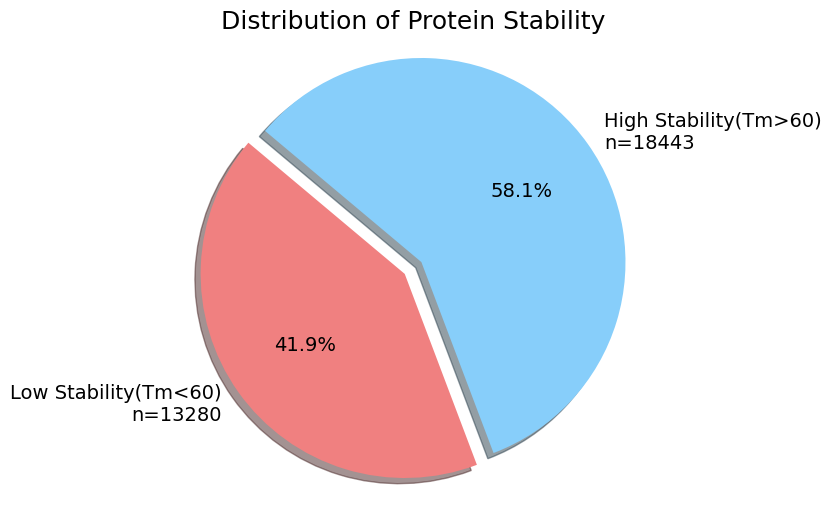

In [9]:
#可视化不同类别蛋白质的数量，使用饼图进行表示
import pandas as pd
import matplotlib.pyplot as plt

# 筛选 Tm > 60 的行作为高热稳定性蛋白
high_stability_proteins = data_raw[data_raw['Tm'] > 60]

# 筛选 Tm < 60 的行作为低热稳定性蛋白
low_stability_proteins = data_raw[data_raw['Tm'] < 60]

# 计算高热稳定性蛋白和低热稳定性蛋白的数量
high_stability_count = len(high_stability_proteins)
low_stability_count = len(low_stability_proteins)

# 绘制饼图
labels = [ 'Low Stability(Tm<60)\nn=13280','High Stability(Tm>60)\nn=18443']
sizes = [ low_stability_count,high_stability_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # 突出显示高热稳定性蛋白
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # 确保饼图是圆形的


plt.title('Distribution of Protein Stability',fontsize=18)
plt.show()


In [10]:
#计算蛋白质的嵌入特征，使用字典将20种氨基酸和0映射成0-20的数字。
aaDict = {'0':0, 'D':1, 'S':2, 'Q':3, 'K':4,
          'I':5, 'P':6, 'T':7, 'F':8, 'N':9,
          'G':10, 'H':11, 'L':12, 'R':13, 'W':14,
          'A':15, 'V':16, 'E':17, 'Y':18, 'M':19, 'C':20}
max_len = 512

# 去处杂原子，过滤掉包含 'U' 或 'X' 的行(更好的做法是保留只包含20种氨基酸的序列，但是这些序列中杂原子只有U和X，我直接去除了)
data_filtered = data_raw[~data_raw['Sequence'].str.contains('U|X')]


par0_c = [[aaDict[x] for x in a] for a in data_filtered['Sequence']]

par0_c = keras.preprocessing.sequence.pad_sequences(par0_c, maxlen=max_len, padding='post')
pssm_par0 =  data_filtered['pssm_par0'].values
pssm_par0 = [x[:512, :].astype('float32') for x in pssm_par0]
pssm_par0 = np.stack(pssm_par0, axis=0).astype('float32')
label = data_filtered['label'].values

In [11]:
all_index = np.arange(label.shape[0])
print('all_index num: {}'.format(all_index.shape))

#使用五折交叉验证进行分类。
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
skf_split = []

for train_index, test_index in skf.split(all_index, label):
    skf_split.append((train_index, test_index))
    
label = to_categorical(label, num_classes=2)

#判断是否有gpu可以使用。
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


fold_count = 0
model_loss = []
model_acc = []
model_top2acc = []
model_m = []
all_true = []
all_pred = []

all_index num: (31663,)


In [ ]:
for train_index, test_index in skf_split:
    
    y_train = label[train_index]

    x_train = [np.r_[par0_c[train_index]],
               np.r_[pssm_par0[train_index]]]
    
    #do shuffle before training
    shuffle_index = np.arange(x_train[0].shape[0])
    np.random.shuffle(shuffle_index)
    
    x_train = [x_train[0][shuffle_index], x_train[1][shuffle_index]]
    y_train = y_train[shuffle_index]
    vali_index, test_index, vali_label, test_label = train_test_split(test_index, label[test_index], test_size=0.8, 
                                                                      stratify=label[test_index], random_state=0)
    
    x_vali = [ par0_c[vali_index],pssm_par0[vali_index]]
    y_vali = label[vali_index]
    
    x_test = [par0_c[test_index],pssm_par0[test_index]]
    y_test = label[test_index]
    print('x_train with data augmentation shape: {}'.format(x_train[0].shape))
    print('x_vali shape: {}'.format(x_vali[0].shape))
    print('x_test shape: {}'.format(x_test[0].shape))

    K.clear_session()
    model = build_model()
    if fold_count == 0:
        model.summary()
    
    print('------fold {}-------'.format(str(fold_count)))

    adam = optimizers.legacy.Adam(learning_rate=0.0002)

    #使用交叉熵作为我们模型的损失函数。
    model.compile(adam, loss='binary_crossentropy', 
                  metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2acc')])
    
    callback = [keras.callbacks.ModelCheckpoint(best_acc_model_path + str(fold_count), monitor='val_acc',
                                                save_best_only=True, save_weights_only=True),
                keras.callbacks.EarlyStopping(monitor='val_acc', patience=12, verbose=0, mode='auto')]

    history = model.fit(
        x_train, y_train, batch_size=64, epochs=150, verbose=2, callbacks=callback, validation_data=(x_vali, y_vali))

    results = model.evaluate(x_test, y_test, verbose=0)
    model_loss.append(results[0])
    model_acc.append(results[1])
    model_top2acc.append(results[2])
    
    y_pred = model.predict(x_test, verbose=0)
    y_true = y_test
    np.savez(test_ba_npz_path + str(fold_count), y_true=y_true, y_pred=y_pred)
    
    np.savez(sample_split_ + str(fold_count), train=train_index, vali=vali_index, test=test_index)
    
    model_m.append(model_metrics(y_test.argmax(axis=-1), y_pred.argmax(axis=-1)))
    all_true.append(y_true)
    all_pred.append(y_pred)
    
    y_pred, y_true = evaluate_model(model, x_test, y_test)
    fold_count += 1

x_train with data augmentation shape: (25330, 512)
x_vali shape: (1266, 512)
x_test shape: (5067, 512)
pssm: (None, 512, 20)
seq: (None, 512, 44)
x: (None, 512, 64)
outputs: Tensor("cn/softmax/Softmax:0", shape=(None, 2), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512, 20)]            0         []                            
                                                                                                  
 cn (cn)                     (None, 2)                    421534    ['input_1[0][0]',             
                                                       

2024-04-23 15:12:42.165022: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1037516800 exceeds 10% of free system memory.


Epoch 1/150
pssm: (None, 512, 20)
seq: (None, 512, 44)
x: (None, 512, 64)
outputs: Tensor("model/cn/softmax/Softmax:0", shape=(None, 2), dtype=float32)
pssm: (None, 512, 20)
seq: (None, 512, 44)
x: (None, 512, 64)
outputs: Tensor("model/cn/softmax/Softmax:0", shape=(None, 2), dtype=float32)


2024-04-23 15:12:49.660902: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-04-23 15:12:50.211088: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-04-23 15:12:50.585741: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-04-23 15:12:51.366750: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


pssm: (None, 512, 20)
seq: (None, 512, 44)
x: (None, 512, 64)
outputs: Tensor("model/cn/softmax/Softmax:0", shape=(None, 2), dtype=float32)
396/396 - 1227s - loss: 0.5809 - acc: 0.6912 - top2acc: 1.0000 - val_loss: 0.4678 - val_acc: 0.7954 - val_top2acc: 1.0000 - 1227s/epoch - 3s/step
Epoch 2/150
396/396 - 1135s - loss: 0.3946 - acc: 0.8306 - top2acc: 1.0000 - val_loss: 0.3504 - val_acc: 0.8507 - val_top2acc: 1.0000 - 1135s/epoch - 3s/step
Epoch 3/150
396/396 - 1173s - loss: 0.3306 - acc: 0.8629 - top2acc: 1.0000 - val_loss: 0.3504 - val_acc: 0.8610 - val_top2acc: 1.0000 - 1173s/epoch - 3s/step
Epoch 4/150
396/396 - 1183s - loss: 0.3196 - acc: 0.8667 - top2acc: 1.0000 - val_loss: 0.3067 - val_acc: 0.8705 - val_top2acc: 1.0000 - 1183s/epoch - 3s/step
Epoch 5/150
396/396 - 1152s - loss: 0.3035 - acc: 0.8757 - top2acc: 1.0000 - val_loss: 0.3310 - val_acc: 0.8784 - val_top2acc: 1.0000 - 1152s/epoch - 3s/step
Epoch 6/150
396/396 - 1095s - loss: 0.2954 - acc: 0.8807 - top2acc: 1.0000 - val_l

In [16]:
#计算5次交叉验证的平均性能
print('model loss: {} , std {}'.format(np.mean(model_loss, axis=0), np.std(model_loss, axis=0)))
print('model ACC: {} , std {}'.format(np.mean(model_acc, axis=0), np.std(model_acc, axis=0)))
print('model metrics: \nprecision\trecall\tf1\tmcc_score\taccuracy\n{} \n std: \n {}'.format(np.mean(model_m, axis=0), np.std(model_m, axis=0)))

model loss: 0.5461711883544922 , std 0.030304003982978153
model ACC: 0.8714724540710449 , std 0.006355027469581224
model metrics: 
precision	recall	f1	mcc_score	accuracy
[[0.84773104 0.84646456 0.84603541 0.73713851 0.87147245]
 [0.89071225 0.88945228 0.8895207  0.73713851 0.87147245]] 
 std: 
 [[0.02099276 0.03995207 0.01194588 0.01398551 0.00635502]
 [0.02276617 0.0226245  0.00446735 0.01398551 0.00635502]]


In [19]:
model_m

[array([[0.87573022, 0.77819726, 0.82408796, 0.7133189 , 0.86106177],
        [0.85238693, 0.92062415, 0.88519243, 0.7133189 , 0.86106177]]),
 array([[0.82826476, 0.87358491, 0.8503214 , 0.73842486, 0.87132425],
        [0.9053338 , 0.869698  , 0.88715819, 0.73842486, 0.87132425]]),
 array([[0.85253012, 0.83443396, 0.84338498, 0.73290478, 0.87033748],
        [0.88268717, 0.89616559, 0.88937532, 0.73290478, 0.87033748]]),
 array([[0.86261369, 0.85040113, 0.85646388, 0.7545707 , 0.88077379],
        [0.89351696, 0.90261283, 0.89804186, 0.7545707 , 0.88077379]]),
 array([[0.81951641, 0.89570552, 0.85591883, 0.74647332, 0.87386498],
        [0.91963636, 0.85816084, 0.8878357 , 0.74647332, 0.87386498]])]

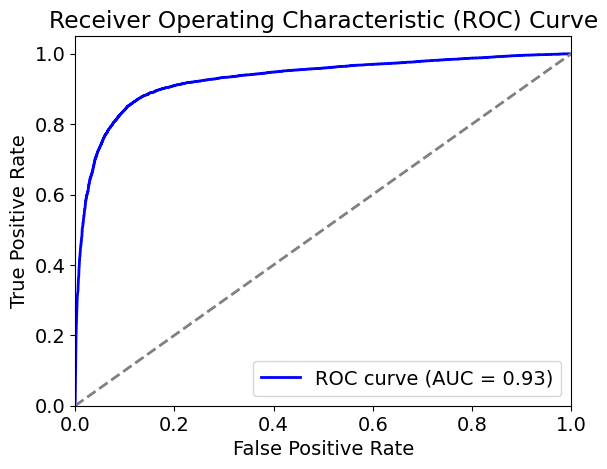

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

data_true = all_true.copy()
data_pred = all_pred.copy()
data_true = data_true[:, 1]
data_pred = data_pred[:, 1]
# 计算ROC曲线的数据
fpr, tpr, thresholds = roc_curve(data_true, data_pred)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()